**get model coordinates**

In [1]:
import plotly.express as px
import pandas as pd
import numpy as np

coor = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/met_ model/distan_lat42.58lon-8.8046p3R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

**get station and sample max gust hour before**

In [2]:
from pandas.core.arrays import categorical
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/station_data/station.csv", usecols = ["time","dir_o"],parse_dates=["time"]).set_index("time")
print("raw data\n",station.head(24))

#show duplicated
df_duplicate = station[station.index.duplicated()]
print("duplicated")
print(df_duplicate)

#delete duplicated and resample
station = station[~station.index.duplicated(keep='first')]
station = station.resample("H",label="right",closed="right").mean()

#label
#dir udr to interval
interval=pd.IntervalIndex.from_tuples([(-0.5,20), (20, 40), (40, 60),
                                       (60,80),(80,100),(100,120),(120,140),(140,160),
                                       (160,180),(180,200),(200,220),(220,240),
                                       (240,260),(260,280),(280,300),(300,320),
                                       (320,340),(340,360)])
labels=['[0, 20]', '(20, 40]', '(40, 60]','(60, 80]', '(80, 100]', '(100, 120]',
        '(120, 140]','(140, 160]', '(160, 180]', '(180, 200]', '(200, 220]',
        '(220, 240]', '(240, 260]', '(260, 280]', '(280, 300]','(300, 320]',
        '(320, 340]', '(340, 360]']
station["dir_o_l"] = pd.cut(station["dir_o"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
station = station.drop(["dir_o"],axis=1)
print("Climatology ")
round(station["dir_o_l"].value_counts(normalize=True),2)


raw data
                      dir_o
time                      
2018-01-01 00:10:00  200.0
2018-01-01 00:20:00  198.0
2018-01-01 00:30:00  198.0
2018-01-01 00:40:00  197.0
2018-01-01 00:50:00  199.0
2018-01-01 01:00:00  199.0
2018-01-01 01:10:00  202.0
2018-01-01 01:20:00  205.0
2018-01-01 01:30:00  201.0
2018-01-01 01:40:00  199.0
2018-01-01 01:50:00  199.0
2018-01-01 02:00:00  202.0
2018-01-01 02:10:00  203.0
2018-01-01 02:20:00  199.0
2018-01-01 02:30:00  196.0
2018-01-01 02:40:00  196.0
2018-01-01 02:50:00  196.0
2018-01-01 03:00:00  198.0
2018-01-01 03:10:00  194.0
2018-01-01 03:20:00  197.0
2018-01-01 03:30:00  209.0
2018-01-01 03:40:00  218.0
2018-01-01 03:50:00  217.0
2018-01-01 04:00:00  207.0
duplicated
                     dir_o
time                      
2018-03-25 03:00:00   54.0
2018-03-25 03:10:00   28.0
2018-03-25 03:20:00   38.0
2018-03-25 03:30:00   45.0
2018-03-25 03:40:00   44.0
2018-03-25 03:50:00   44.0
2019-03-31 03:00:00   49.0
2019-03-31 03:10:00   53.0
2019-03

(40, 60]      0.21
(200, 220]    0.13
(20, 40]      0.12
(180, 200]    0.10
(220, 240]    0.08
(60, 80]      0.06
(240, 260]    0.05
(160, 180]    0.05
(260, 280]    0.04
(80, 100]     0.03
(140, 160]    0.03
(120, 140]    0.02
(280, 300]    0.02
(100, 120]    0.02
[0, 20]       0.01
(300, 320]    0.01
(320, 340]    0.01
(340, 360]    0.00
Name: dir_o_l, dtype: float64

**get meteorologic model d2**

In [3]:
#ria forecast d0
met_model = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/met_ model/lat42.58lon-8.8046p3R4KmD2.csv",parse_dates=["time"]).drop(columns=["Unnamed: 0"]).set_index("time")
met_model.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2018-01-03 00:00:00 to 2023-01-03 23:00:00
Data columns (total 75 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dir0         43824 non-null  float64
 1   snow_prec0   43824 non-null  float64
 2   snowlevel0   43824 non-null  float64
 3   mod0         43824 non-null  float64
 4   wind_gust0   43824 non-null  float64
 5   mslp0        43824 non-null  float64
 6   temp0        43824 non-null  float64
 7   rh0          43824 non-null  float64
 8   visibility0  43824 non-null  float64
 9   lhflx0       43824 non-null  float64
 10  lwflx0       43824 non-null  float64
 11  conv_prec0   43824 non-null  float64
 12  prec0        43824 non-null  float64
 13  swflx0       43824 non-null  float64
 14  shflx0       43824 non-null  float64
 15  cape0        43824 non-null  float64
 16  cin0         43824 non-null  float64
 17  cfh0         43824 non-null  float64
 18  cfl0       

**Concatenate and dropnan**

In [4]:
df_all = pd.concat([station,met_model],axis=1).dropna()
df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43108 entries, 2018-01-03 00:00:00 to 2022-12-31 00:00:00
Data columns (total 76 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   dir_o_l      43108 non-null  category
 1   dir0         43108 non-null  float64 
 2   snow_prec0   43108 non-null  float64 
 3   snowlevel0   43108 non-null  float64 
 4   mod0         43108 non-null  float64 
 5   wind_gust0   43108 non-null  float64 
 6   mslp0        43108 non-null  float64 
 7   temp0        43108 non-null  float64 
 8   rh0          43108 non-null  float64 
 9   visibility0  43108 non-null  float64 
 10  lhflx0       43108 non-null  float64 
 11  lwflx0       43108 non-null  float64 
 12  conv_prec0   43108 non-null  float64 
 13  prec0        43108 non-null  float64 
 14  swflx0       43108 non-null  float64 
 15  shflx0       43108 non-null  float64 
 16  cape0        43108 non-null  float64 
 17  cin0         43108 non-null  float

**Compare accuracy dir0, dir1, dir2 versus dir_o_l**

/usr/local/lib/python3.8/dist-packages/pandas/core/reshape/pivot.py:188: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



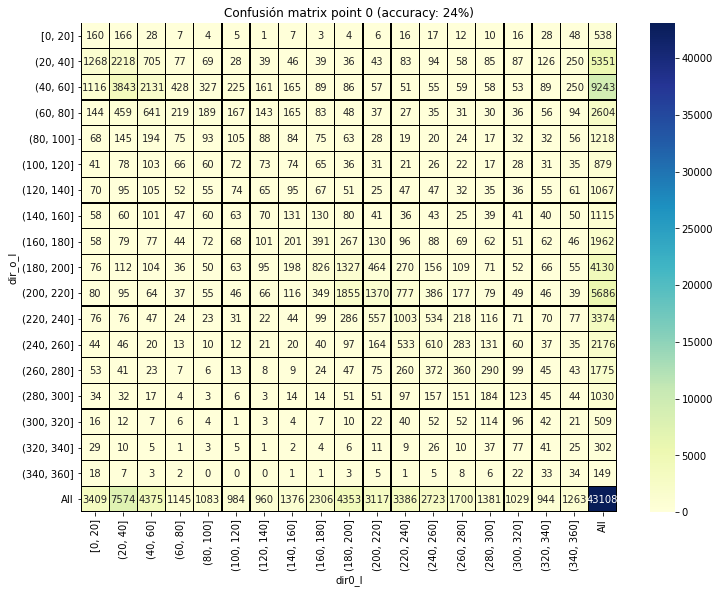

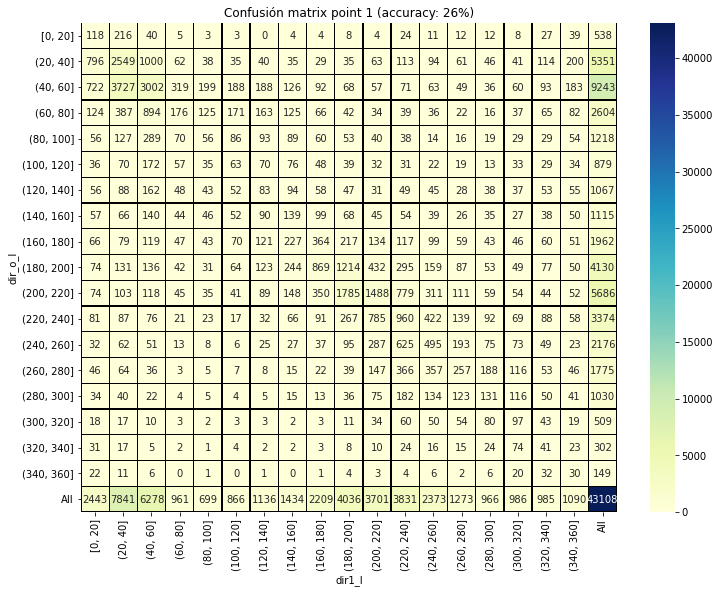

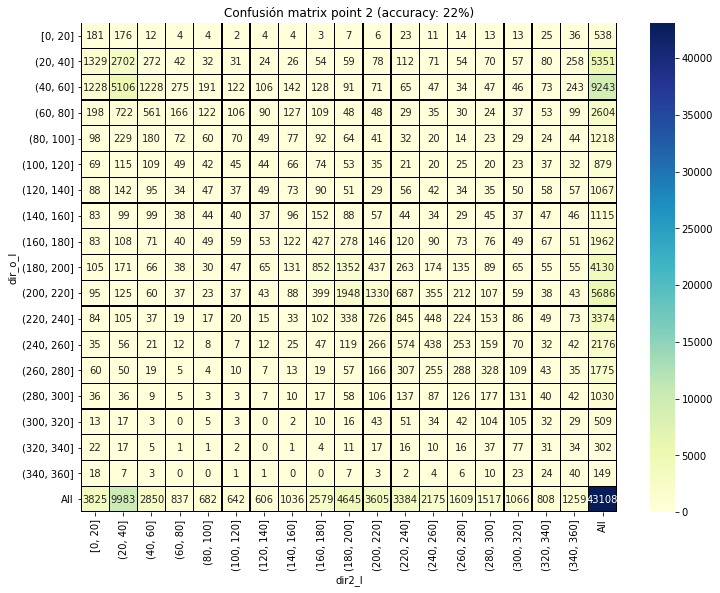

In [5]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

#label dir 0,1 and 2
df_all["dir0_l"] = pd.cut(df_all["dir0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_all["dir1_l"] = pd.cut(df_all["dir1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_all["dir2_l"] = pd.cut(df_all["dir2"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')

acc0 = accuracy_score(df_all.dir_o_l, df_all.dir0_l)
acc1 = accuracy_score(df_all.dir_o_l, df_all.dir1_l)
acc2 = accuracy_score(df_all.dir_o_l, df_all.dir2_l)

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 0 (accuracy: {:.0%})".format(acc0))
global_sc = pd.crosstab(df_all.dir_o_l, df_all.dir0_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 1 (accuracy: {:.0%})".format(acc1))
global_sc = pd.crosstab(df_all.dir_o_l, df_all.dir1_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 2 (accuracy: {:.0%})".format(acc2))
global_sc = pd.crosstab(df_all.dir_o_l, df_all.dir2_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

#delete met model label columns
df_all = df_all.drop(["dir0_l","dir1_l","dir2_l"],axis=1)

**Add time variables. Train machine learning and results**

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable
Y = df_all.dir_o_l
X = df_all[["wind_gust0","mod0","dir0","wind_gust1","mod1","dir1","wind_gust2",
            "mod2","dir2","hour","month","dayofyear","weekofyear"]]

acc_t = []
for t in range (0,20):
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, )
  ml_model = LGBMClassifier(n_estimators=200).fit(X_train,y_train)
  #ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc_t.append(round(accuracy_score(y_test,y_pred),2))
  print("machine learning number:",t)
  
 
print("Accuracy Machine learning models")
df_r=pd.DataFrame({"acc_t":acc_t,});
df_r.describe()



machine learning number: 0
machine learning number: 1
machine learning number: 2
machine learning number: 3
machine learning number: 4
machine learning number: 5
machine learning number: 6
machine learning number: 7
machine learning number: 8
machine learning number: 9
machine learning number: 10
machine learning number: 11
machine learning number: 12
machine learning number: 13
machine learning number: 14
machine learning number: 15
machine learning number: 16
machine learning number: 17
machine learning number: 18
machine learning number: 19
Accuracy Machine learning models


,acc_t
count,20.000000
mean,0.410500
std,0.009445
min,0.400000
25%,0.400000
50%,0.410000
75%,0.412500
max,0.430000


**Show machine learning results**

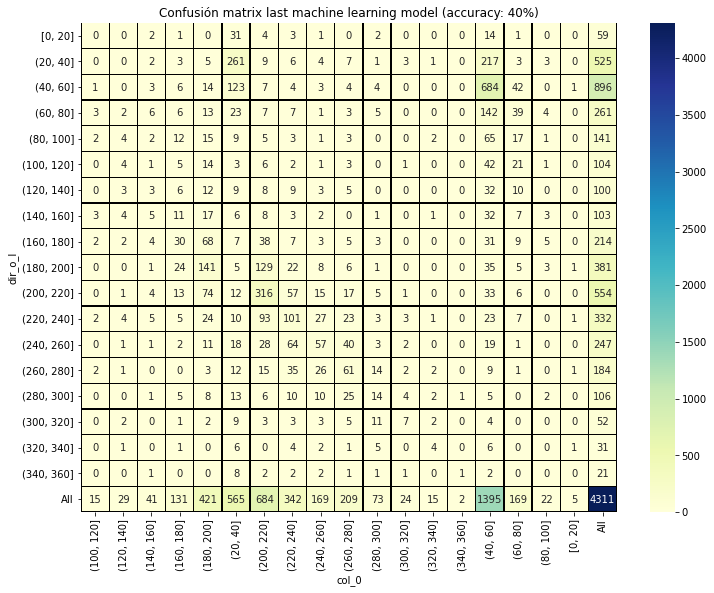

In [7]:
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix last machine learning model (accuracy: {:.0%})".format(acc_t[-1]))
global_sc = pd.crosstab(y_test, y_pred, margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

**Save algorithm**

In [8]:
import pickle
from sklearn.pipeline import Pipeline


estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)
print(pipe)
al_file={"x_var":X.columns,"coor":coor,"pipe":pipe}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/Coron/algorithms/dir_coron_d2.al", 'wb'))

Pipeline(steps=[('ml_model', LGBMClassifier(n_estimators=200))])
